In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import numpy  as np 
import xarray as xr

import matplotlib.pyplot  as plt
import GDa.graphics.plot  as plot
import matplotlib.patches as patches
import matplotlib

from   GDa.session           import session_info, session
from   GDa.signal.surrogates import trial_swap_surrogates

from xfrites.conn.conn_spec  import conn_spec

from tqdm import tqdm

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

### Defining Morlet parameters

In [3]:
from mne.time_frequency import morlet

In [4]:
f_c      = np.linspace(3, 75, 10)
n_cycles = f_c/4.0
sfreq    = 1000. 

In [5]:
W = morlet(sfreq, f_c, n_cycles=n_cycles, sigma=None, zero_mean=False)

In [6]:
P = []
for i in range(len(W)): 
    Wfft = np.fft.fft(W[i], n=5000)
    P   += [(Wfft*np.conj(Wfft)).real]
    P[i] = P[i]/np.max(P[i])
f_ax = np.linspace(0, sfreq, len(Wfft))

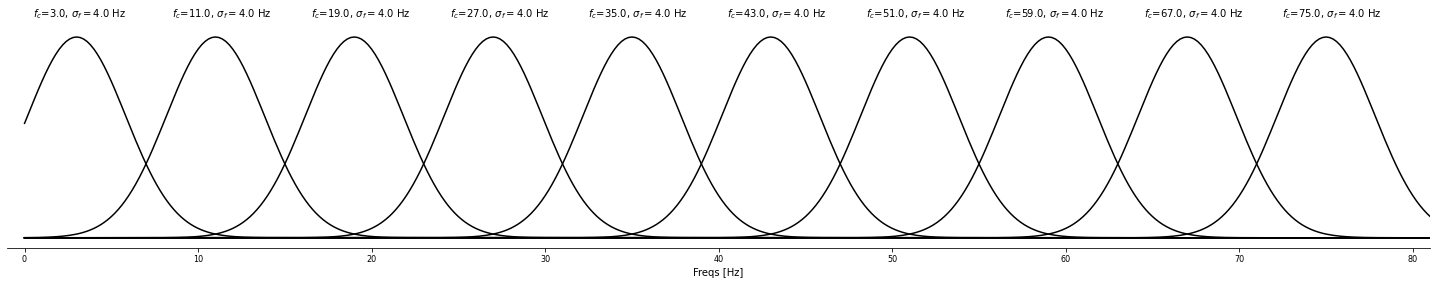

In [7]:
fig = plt.figure(figsize=(20,4))
ax  = plt.subplot(111)
for i in range(len(f_c)):
    plt.plot(f_ax, P[i], color="k")
    plt.xlim(-1,81)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.yticks([])
    plt.text(f_c[i]-2.5, 1.1, r"$f_{c}$="+str(f_c[i])+r", $\sigma_f=$"+str(f_c[i]/n_cycles[i]) + " Hz", fontsize=MEDIUM_SIZE)
    plt.xlabel("Freqs [Hz]")
plt.tight_layout()

#### Loading data

In [8]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '141017', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1])

In [9]:
#### Surrogate data
data_surr = trial_swap_surrogates(data, seed = 500, verbose=False)

#### Choosing pair of regions

These channel pairs display spectral peaks and strong coherence in Band 2. There are 2 short distance pairs (12-17, 17-18) and 1 long distance pair (17-181).

- 12 vs 17
- 17 vs 18
- 17 vs 181

These channel pairs display spectral peaks and strong coherence in Band 4. Both pairs are median distance examples.

- 69 vs 104
- 96 vs 106

In [10]:
channel_labels = np.array([12, 17, 18, 181, 69,104,95,106])

In [11]:
channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where( data.attrs["channels_labels"]==c )[0][0]]

In [12]:
print(f"{channel_indexes=}")

channel_indexes=[6, 11, 12, 65, 30, 39, 36, 41]


In [13]:
pairs = np.array([[6,11],
                  [11,12],
                  [11,65],
                  [30,39],
                  [36,41]])

### Spectral analysis

#### Static Fourier analysis

Here we plot the power-spectra and coherence of the channels of interested based of conventional Fourier analysis averaged over trials.

In [14]:
######################################################################################
######################################################################################
# Define function to plot power spectra
######################################################################################
######################################################################################
def plot_power_spectra(f, px, py, pxy, title=None):
    """
    f: Frequency axis
    px: Power spectra of signal X (n_trials, n_freqs)
    py: Power spectra of signal Y (n_trials, n_freqs)
    pxy: Cross-spectra between X and Y (n_trials, n_freqs)
    title: Title to insert in the plot
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    fig = plt.figure(figsize=(7., 3.8), dpi=150)

    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.1, right=0.95, bottom=0.55, top=0.92)
    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.1, right=0.95, bottom=0.13, top=0.50)

    ######################################################################################
    ######################################################################################
    # Power spectra
    ######################################################################################
    ######################################################################################
    ax1 = plt.subplot(gs1[0])


    plt.sca(ax1)
    plt.plot(f,px.mean(axis=0).real)
    plt.plot(f,py.mean(axis=0).real)
    plt.ticklabel_format(axis='both', style='sci', scilimits=(0,1e-4))
    plt.ylabel("Power")
    plt.xticks([])
    plt.xlim(0,80)
    plt.title(title)
    axins = inset_axes(ax1, width="100%", height="100%", loc='upper left',
                       bbox_to_anchor=(0.67,1.0,.25,.4), bbox_transform=ax.transAxes)
    plt.plot(f,px.mean(axis=0).real)
    plt.plot(f,py.mean(axis=0).real)
    plt.xlim(50,75)
    plt.yticks([])
    plt.ylim(0, 0.00005)

    # Panel B
    ax2 = plt.subplot(gs2[0])

    plt.sca(ax2)
    # Compute coherence
    C = np.abs(pxy.mean(0))**2 / (px.mean(0) * py.mean(0))
    plt.plot(f,C.real)
    plt.xlim(0,80)
    plt.ylabel("Coherence")
    plt.xlabel("Frequency [Hz]")

    bg = plot.Background(visible=False)

    plot.add_panel_letters(fig, axes=[ax1, ax2], fontsize=12,
                           xpos=[-0.1, -0.1], ypos=[1,1])

##### a8B-a8M

In [197]:
# Fourier transform
xfft = np.fft.fft( ses.data.isel(roi=6),  n=50000, axis=-1)
yfft = np.fft.fft( ses.data.isel(roi=11), n=50000, axis=-1)
# Compute spectra and frequency axis
px  = xfft*np.conj(xfft)
py  = yfft*np.conj(yfft)
pxy = xfft*np.conj(yfft)
f   = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

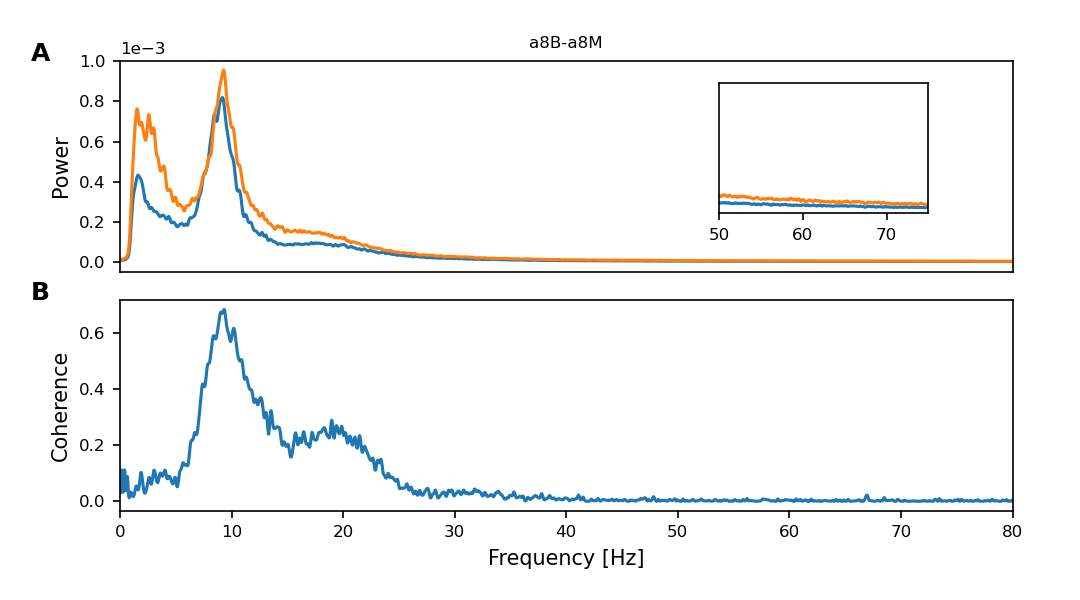

In [199]:
plot_power_spectra(f, px, py, pxy, title="a8B-a8M")

##### a8B-a8M

In [200]:
# Fourier transform
xfft = np.fft.fft( ses.data.isel(roi=11),  n=50000, axis=-1)
yfft = np.fft.fft( ses.data.isel(roi=12), n=50000, axis=-1)
# Compute spectra and frequency axis
px  = xfft*np.conj(xfft)
py  = yfft*np.conj(yfft)
pxy = xfft*np.conj(yfft)
f   = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

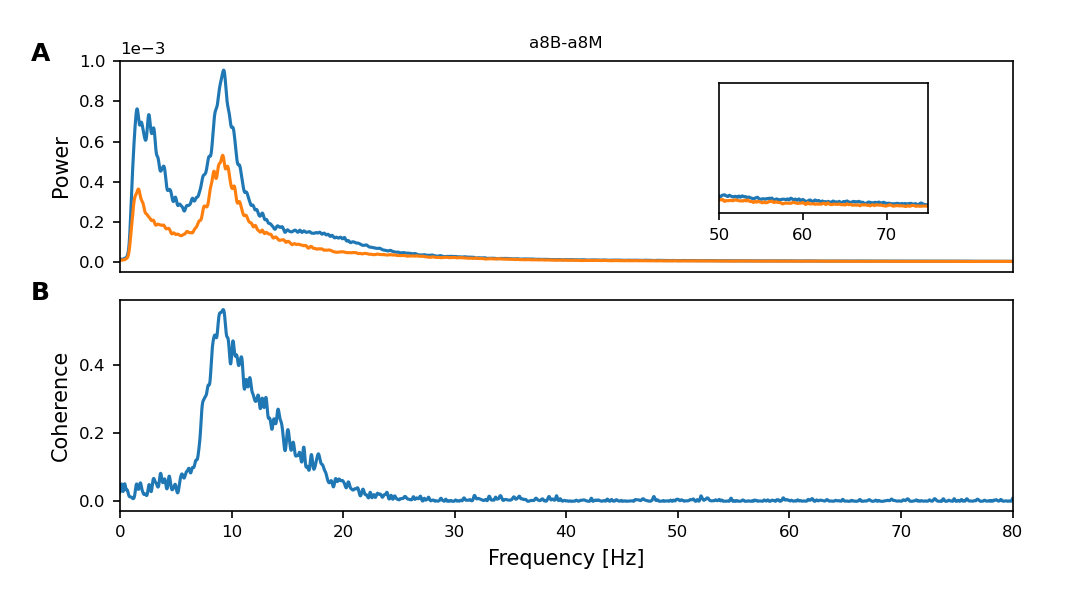

In [201]:
plot_power_spectra(f, px, py, pxy, title="a8B-a8M")

##### a7A-a8M

In [202]:
# Fourier transform
xfft = np.fft.fft( ses.data.isel(roi=11),  n=50000, axis=-1)
yfft = np.fft.fft( ses.data.isel(roi=65), n=50000, axis=-1)
# Compute spectra and frequency axis
px  = xfft*np.conj(xfft)
py  = yfft*np.conj(yfft)
pxy = xfft*np.conj(yfft)
f   = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

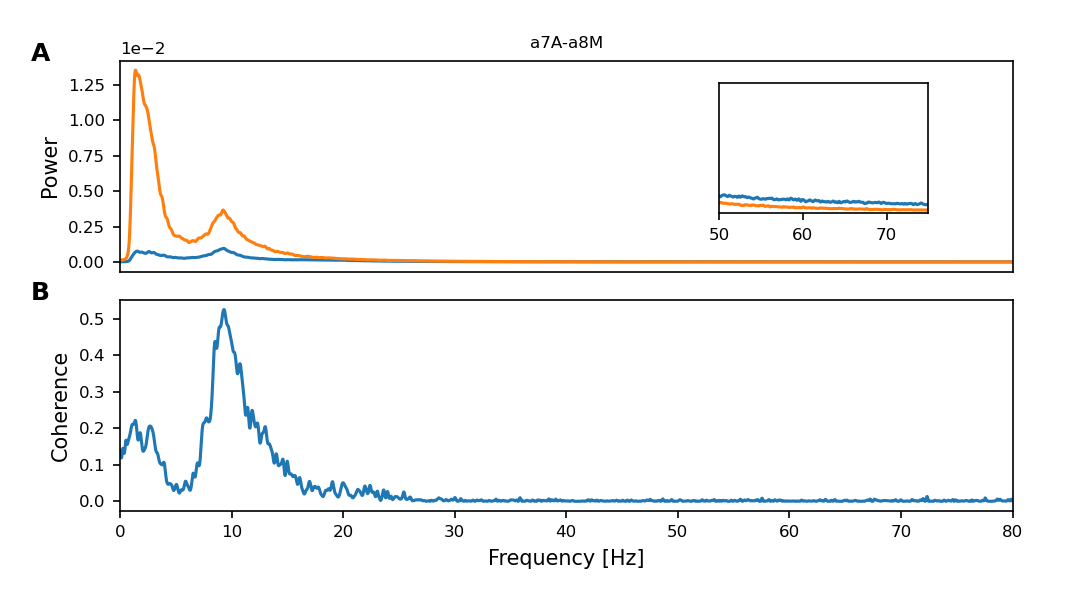

In [203]:
plot_power_spectra(f, px, py, pxy, title="a7A-a8M")

##### F1-F1

In [204]:
# Fourier transform
xfft = np.fft.fft( ses.data.isel(roi=30),  n=50000, axis=-1)
yfft = np.fft.fft( ses.data.isel(roi=39), n=50000, axis=-1)
# Compute spectra and frequency axis
px  = xfft*np.conj(xfft)
py  = yfft*np.conj(yfft)
pxy = xfft*np.conj(yfft)
f   = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

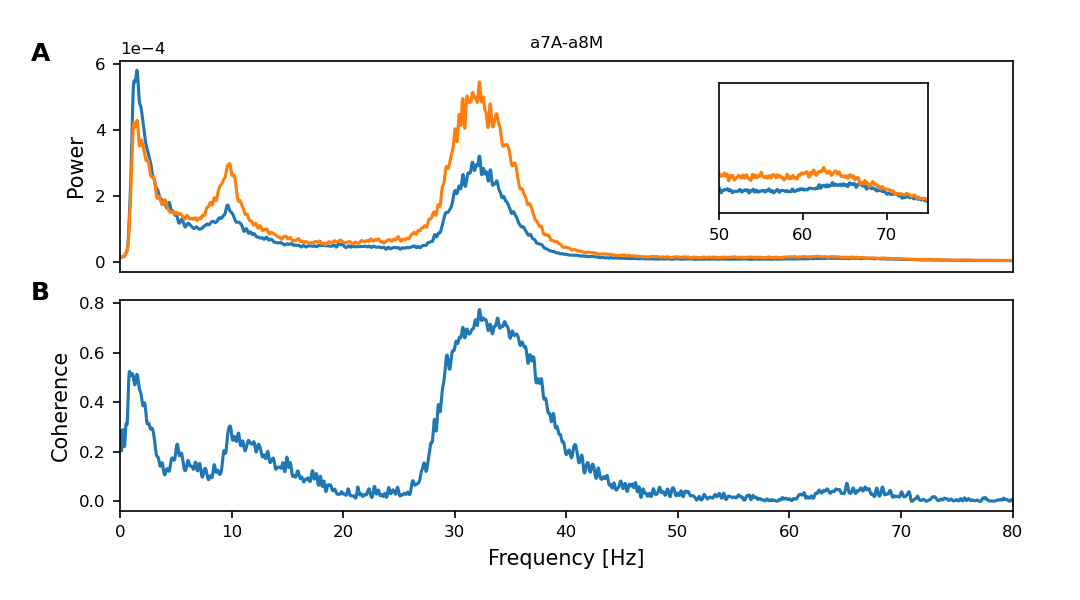

In [205]:
plot_power_spectra(f, px, py, pxy, title="a7A-a8M")

##### a3-F1

In [206]:
# Fourier transform
xfft = np.fft.fft( ses.data.isel(roi=36),  n=50000, axis=-1)
yfft = np.fft.fft( ses.data.isel(roi=41), n=50000, axis=-1)
# Compute spectra and frequency axis
px  = xfft*np.conj(xfft)
py  = yfft*np.conj(yfft)
pxy = xfft*np.conj(yfft)
f   = np.linspace(0, ses.data.attrs["fsample"], xfft.shape[1])

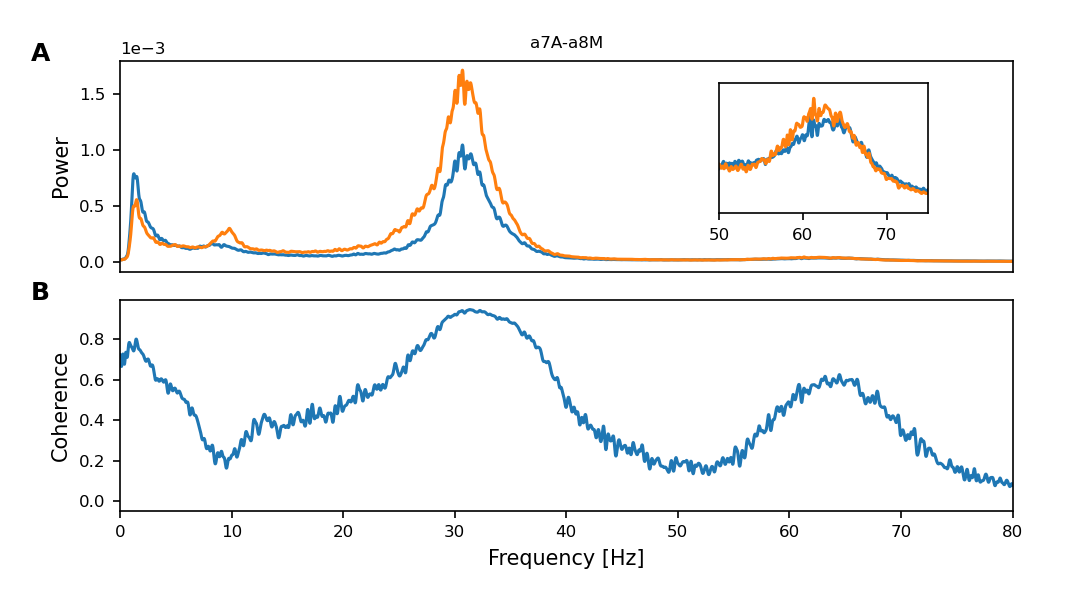

In [207]:
plot_power_spectra(f, px, py, pxy, title="a7A-a8M")

#### Time-resolved coherence

In [55]:
# Smoothing windows
sm_times  = 0.3
sm_freqs  = 1
sm_kernel = "square"
decim     = 15

# Defining parameters
mode  = 'morlet' 

n_freqs  = 30
freqs    = np.linspace(.1, 80, n_freqs)
sigma_f  = 4.
n_cycles = freqs/sigma_f

In [56]:
kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=20, pairs=pairs,
    mode=mode, n_cycles=n_cycles, decim=decim, metric="coh", sm_kernel=sm_kernel,
    sm_times=sm_times, sm_freqs=sm_freqs, block_size=1,mt_bandwidth=None,
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=30, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:   10.1s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   13.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   13.9s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [57]:
# compute the coherence for each surrogate
coh_surr = conn_spec(data_surr, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=30, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:   12.1s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:   12.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

##### Estimating the bias

Following Lachaux et. al. (2002) the bias fo the wavelet coherence can be computed as:

$B = \left(1 + 2\frac{n_{cy}}{n_{co}}\right)^{-1}$

where, $n_{cy}$ is the number of cycles of the wavelet within the integration window $\delta$, and $n_{co}$ the number of cycles of the wavelet. The integration window is given by:

$\delta = n_{cy}/f$

Those function could be used to fit the bias of the wavelet coherence computed for white noise signals.

With our terminology, since we input $\delta$ (sm_times) to the function the bias can be written as:

$B = \left(1 + 2\frac{f\delta}{n_{co}}\right)^{-1}$

From this equation it is expected that the bias will be frequency dependent if $n_{co}$ is constant, and frequency independent if $n_{co}$ is proportional to frequency let's say $n_{co}=f/\sigma_f$, then:

$B = \left(1 + 2\delta\sigma_{t}\right)^{-1}$

By comparing the wavelet coherence measured for white noise we can validate the expression above.

In [211]:
def _bias_lachaux(sm_times, freqs, n_cycles):
    return (1+2*sm_times*freqs/n_cycles)**-1

In [212]:
n  = 3650
sf = 1000

eta = xr.DataArray( np.random.normal(0,1,size=(1,30,n)), 
                    dims=("trials","roi","times"), 
                    coords={"times": np.arange(n)/sf})

In [214]:
delta    = 1
freqs    = np.linspace(10,100,30)
w_t      = np.linspace(0.1, 1, 10)

n_cycles = freqs/sigma_f

kw = dict(
    freqs=freqs, times="times", roi="roi", foi=None, n_jobs=20, pairs=None, sfreq=1000,
    mode=mode, n_cycles=n_cycles, decim=delta, metric="coh", sm_kernel="square",
    sm_freqs=1, block_size=1
)

coh_eta = []
for i in range( len(w_t) ):
    kw["sm_times"] = w_t[i]
    coh_eta += [conn_spec(eta, **kw)]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=100, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.8s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.9s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=200, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.6s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=300, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.6s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=400, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    1.8s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=500, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    2.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=600, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    2.0s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=700, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    2.0s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    2.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=800, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    2.0s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    2.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=900, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    2.0s remaining:    1.4s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    2.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=435, n_freqs=30, decim=1, sm_times=1000, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  18 out of  30 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=20)]: Done  25 out of  30 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=20)]: Done  30 out of  30 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...0 : 0/435 [00:00<?,       ?it/s]

In [215]:
B   = []
B_t = []

for i in range( len(w_t) ):
    B   += [coh_eta[i].isel(times=slice(20,-20)).squeeze().mean(dim=("roi","times"))]
    B_t += [_bias_lachaux(w_t[i], freqs, n_cycles) ]

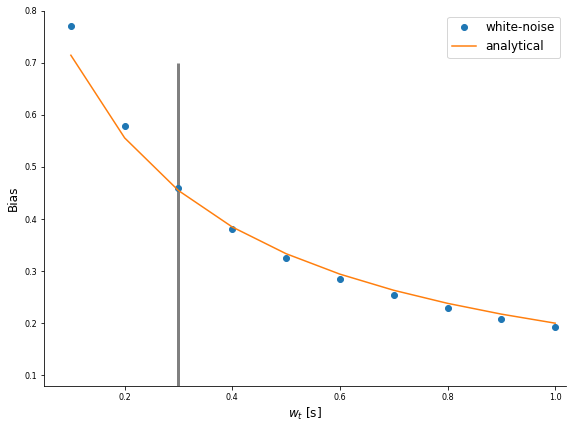

In [220]:
fig = plt.figure(figsize=(8,6))
ax  = plt.subplot(111)
B_total   = np.mean(B, -1)
B_t_total = np.mean(B_t, -1)
plt.plot(w_t, B_total, "o", label="white-noise")
plt.plot(w_t, B_t_total, "-", label="analytical")
plt.legend(fontsize=BIGGER_SIZE)
plt.vlines(0.3, 0, .7, "gray", lw=3)
plt.ylim(0.08, .8)
plt.xlim(0.05, 1.02)
plt.ylabel("Bias", fontsize=BIGGER_SIZE)
plt.xlabel(r"$w_t$ [s]", fontsize=BIGGER_SIZE)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()

##### Single-trials of time-resolved coherence

##### Correcting the coherence values
Here, we correct the coherence values using the $95\%$ percentile of the surrogate coherence taken across the trials dimension. We also consider that correcting the coherence values by removing non-siginificant values we also correct for the bias, since it is also prenset in the surrogate coherences.

In [116]:
pairs

array([[ 6, 11],
       [11, 12],
       [11, 65],
       [30, 39],
       [36, 41]])

In [117]:
# Eliminating non-siginificant values
coh_sig = np.clip(coh-coh_surr, 0, np.inf)

No handles with labels found to put in legend.


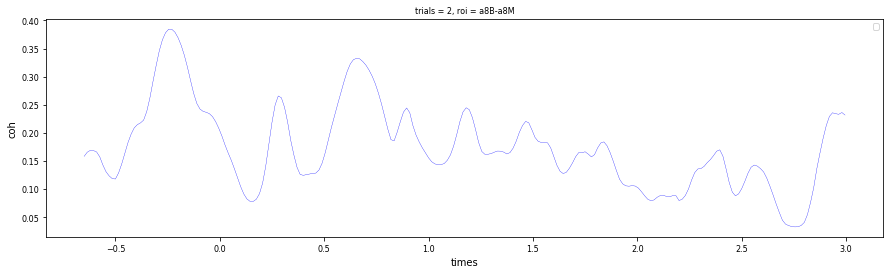

In [127]:
plt.figure(figsize=(15,4))
coh_sig.mean("freqs").isel(roi=0).sel(trials=2).plot(x="times", hue="trials", color="blue", lw=.3);
plt.legend()

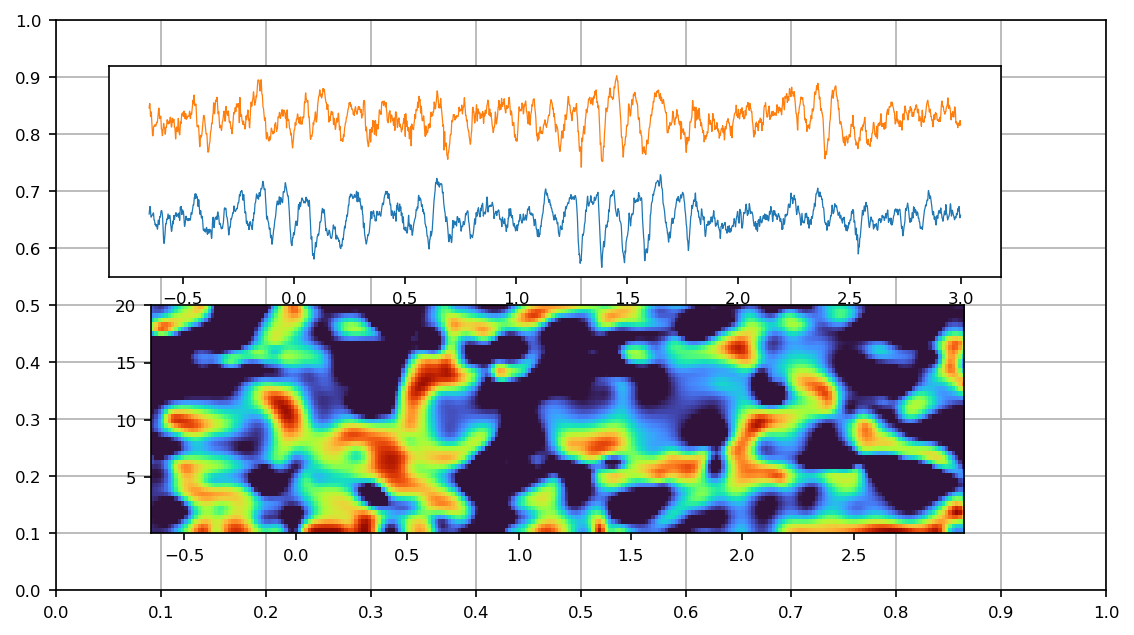

In [119]:
fig = plt.figure(figsize=(7., 3.8), dpi=150)

gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.90,  bottom=0.55, top=0.92)
gs2 = fig.add_gridspec(nrows=1, ncols=1, left=0.09, right=0.865, bottom=0.1, top=0.50)
gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.92, right=0.94, bottom=0.07, top=0.45)


ax1 = plt.subplot(gs1[0])

plt.sca(ax1)
plt.plot(ses.data.time, ses.data.isel(roi=6).sel(trials=10), lw=.6, label=ses.data.roi.values[36])
plt.plot(ses.data.time, ses.data.isel(roi=11).sel(trials=10)+4e-4, lw=.6, label=ses.data.roi.values[36])
#plt.axis("off")
plt.yticks([])

ax2 = plt.subplot(gs2[0])

plt.sca(ax2)
extent=[coh_sig.times[0], coh_sig.times[-1], coh_sig.freqs[0], coh_sig.freqs[-1]]
plt.imshow( coh_sig.isel(roi=0).sel(trials=10), aspect="auto", cmap="turbo", 
            vmin=0, vmax=1, origin="lower", interpolation=None, extent=extent ) 

#ax3 = plt.subplot(gs3[0])

bg = plot.Background(visible=True)

#plot.add_panel_letters(fig, axes=[ax1, ax2], fontsize=12,
#                       xpos=[-0.1, -0.1], ypos=[1,1])

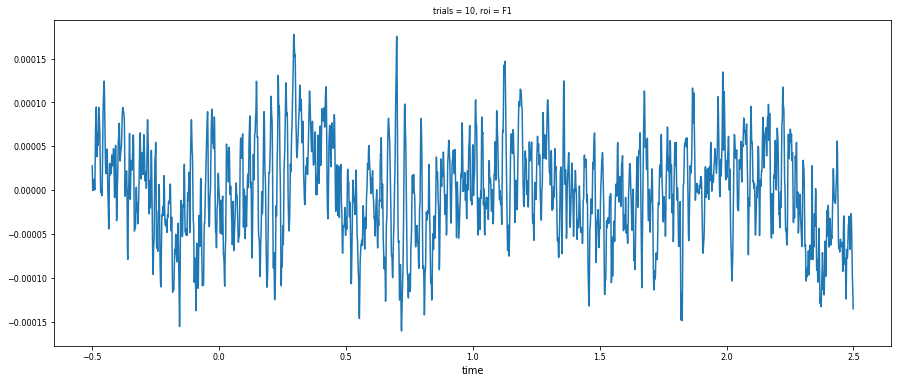

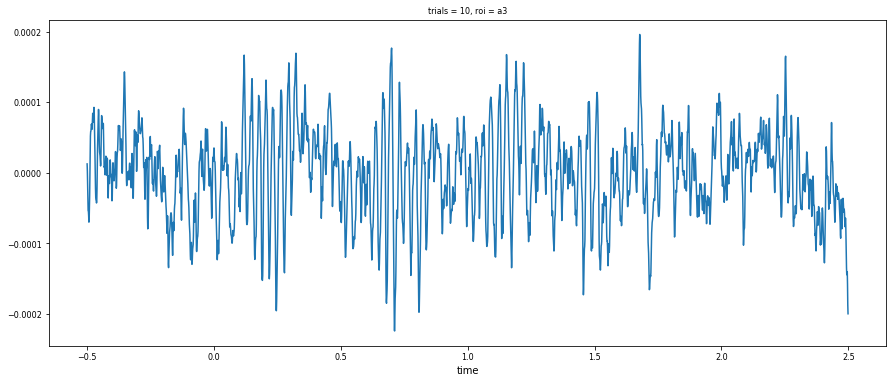

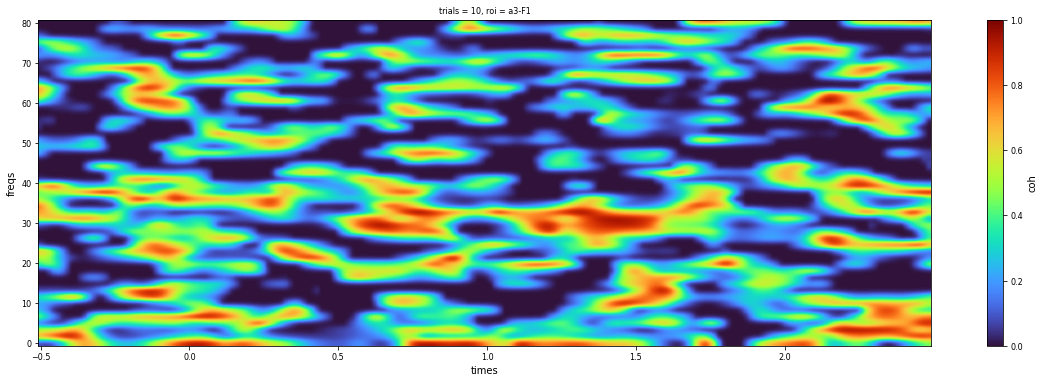

In [27]:
plt.figure(figsize=(15,6))
ses.data.isel(roi=36).sel(trials=10,time=slice(-0.5,2.5)).plot(x="time")
plt.figure(figsize=(15,6))
ses.data.isel(roi=41).sel(trials=10,time=slice(-0.5,2.5)).plot(x="time")
plt.figure(figsize=(20,6))
coh_sig.isel(roi=4).sel(trials=10,times=slice(-0.5,2.5)).plot.imshow(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1, interpolation="gaussian")

In [58]:
from xfrites.conn.conn_coh import conn_coherence_hilbert

In [59]:
kw = dict(
    times="time", roi="roi", freqs=freqs, f_bw=np.array([sigma_f]*len(freqs)), n_jobs=20, 
     decim=decim,  block_size=1, kw_filter=dict(method="iir"), pairs=pairs, sm_kernel=sm_kernel, sm_times=sm_times, 
)

In [ ]:
coh_hil = conn_coherence_hilbert(data, **kw);
coh_hil_surr = conn_coherence_hilbert(data_surr, **kw)

Setting up low-pass filter at 4.1 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 4.10 Hz: -6.02 dB



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 1408 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 16384 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 26320 tasks      | elapsed:    7.7s


Setting up low-pass filter at 6.9 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 6.86 Hz: -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    8.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.4s


Setting up band-pass filter from 1.6 - 9.6 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.61, 9.61 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.7s


Setting up band-pass filter from 4.4 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.37, 12.37 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    6.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 7.1 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.12, 15.12 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.5s


Setting up band-pass filter from 9.9 - 18 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.88, 17.88 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 13 - 21 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 12.63, 20.63 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.0s


Setting up band-pass filter from 15 - 23 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 15.39, 23.39 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.9s


Setting up band-pass filter from 18 - 26 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 18.14, 26.14 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.5s


Setting up band-pass filter from 21 - 29 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 20.90, 28.90 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.9s


Setting up band-pass filter from 24 - 32 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 23.65, 31.65 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.1s


Setting up band-pass filter from 26 - 34 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 26.41, 34.41 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.8s


Setting up band-pass filter from 29 - 37 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 29.16, 37.16 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.4s


Setting up band-pass filter from 32 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 31.92, 39.92 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.5s


Setting up band-pass filter from 35 - 43 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 34.67, 42.67 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.5s


Setting up band-pass filter from 37 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 37.43, 45.43 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 40 - 48 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 40.18, 48.18 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.1s


Setting up band-pass filter from 43 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 42.94, 50.94 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.2s


Setting up band-pass filter from 46 - 54 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 45.69, 53.69 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.1s


Setting up band-pass filter from 48 - 56 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 48.45, 56.45 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 51 - 59 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 51.20, 59.20 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.6s


Setting up band-pass filter from 54 - 62 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 53.96, 61.96 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.5s


Setting up band-pass filter from 57 - 65 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 56.71, 64.71 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 59 - 67 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.47, 67.47 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 62 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 62.22, 70.22 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.4s


Setting up band-pass filter from 65 - 73 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 64.98, 72.98 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 110 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.2s


Setting up band-pass filter from 68 - 76 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 67.73, 75.73 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.1s


Setting up band-pass filter from 70 - 78 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 70.49, 78.49 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    4.8s


Setting up band-pass filter from 73 - 81 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 73.24, 81.24 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.3s


Setting up band-pass filter from 76 - 84 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 76.00, 84.00 Hz: -6.02, -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 26460 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    5.7s finished
Compute pairwise coherence (n_pairs=5, n_freqs=30, decim=15


x_filt.shape=(30, 332, 82, 244)


  0%|          | Estimating pairwise coherence : 0/5 [00:00<?,       ?it/s]

np.shape(coh_tr)=(5, 30, 332, 244)
Setting up low-pass filter at 4.1 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 4.10 Hz: -6.02 dB



/hdd/projects/xfrites/xfrites/conn/conn_coh.py:152: ComplexWarning: Casting complex values to real discards the imaginary part
  coh[:,tr,...] = np.stack(coh_tr, axis=2)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  71 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.3s
[Parallel(n_jobs=20)]: Done 16384 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done 26320 tasks      | elapsed:    7.5s


Setting up low-pass filter at 6.9 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 6.86 Hz: -6.02 dB



[Parallel(n_jobs=20)]: Done 27224 out of 27224 | elapsed:    7.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 108 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 2796 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 18924 tasks      | elapsed:    3.6s


In [31]:
aux1 = np.clip(coh-coh_surr, 0, np.inf)
aux2 = np.clip(coh_hil-coh_hil_surr, 0, np.inf)

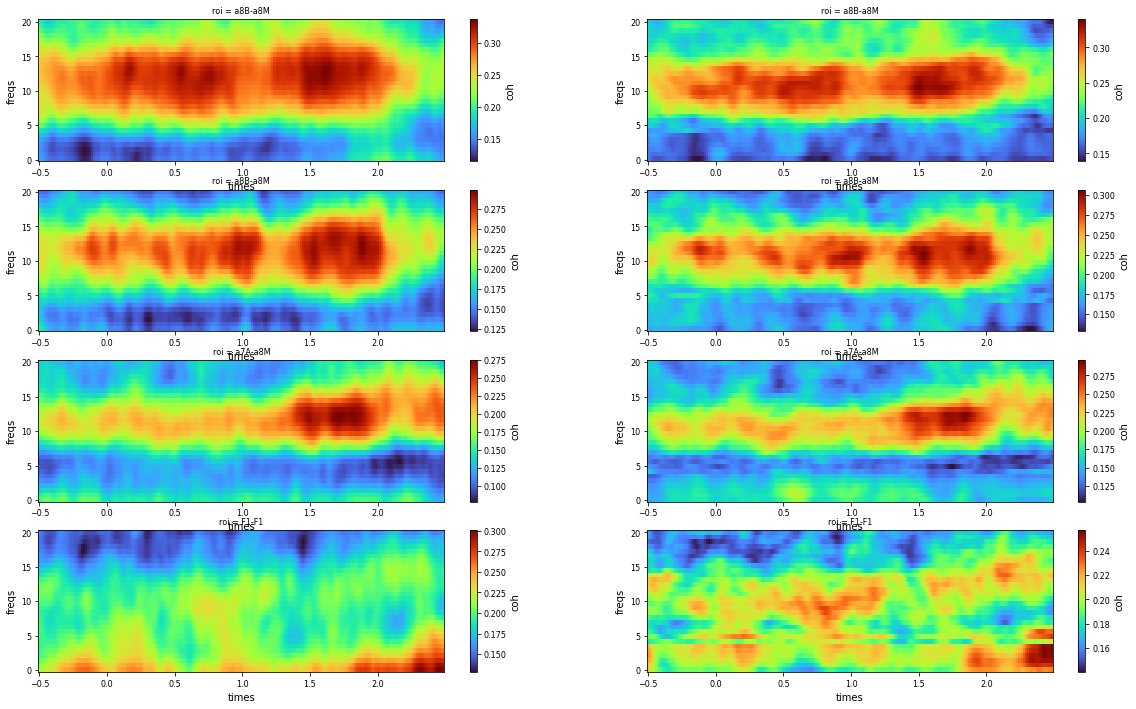

In [54]:
plt.figure(figsize=(20,12))
count = 1
for roi in range(4):
    plt.subplot(4,2,count)
    aux1.isel(roi=roi).sel(times=slice(-0.5,2.5)).mean("trials").plot.imshow(x="times", y="freqs", cmap="turbo")
    count += 1
    plt.subplot(4,2,count)
    aux2.isel(roi=roi).sel(times=slice(-0.5,2.5)).mean("trials").plot.imshow(x="times", y="freqs", cmap="turbo")
    count += 1

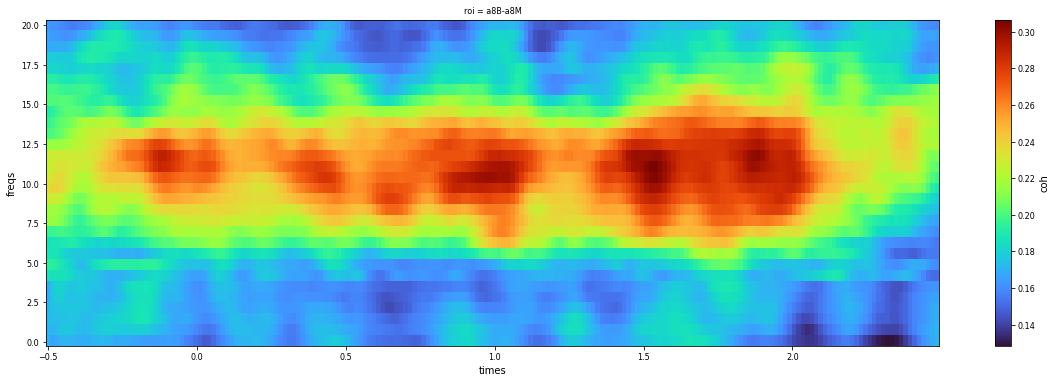

In [44]:
plt.figure(figsize=(20,6))
aux2.isel(roi=1).sel(times=slice(-0.5,2.5)).mean("trials").plot.imshow(x="times", y="freqs", cmap="turbo")